# Валидация - а зачем?

<center> <img src = 'https://scikit-learn.org/stable/_images/grid_search_workflow.png' width=900> </center>

* Sci-kit Learn https://scikit-learn.org/stable/modules/cross_validation.html

* `KFold` - Кросс-итератор для K-фолдовой валидации
* `StratifiedKFold` - он же, но еще и стратифицированный (сбалансированный)
* `GroupKFold` - K-фрагментный вариант итератора с непересекающимися группами.
* `RepeatedKFold` - K-фолдная валидация с повторениями

* `StratifiedGroupKFold` - он же, но еще и стратифицированный (сбалансированный)
* `RepeatedStratifiedKFold` - а тут стратифицированный, но еще дополнительно с повторениями

А где `RepeatedStratifiedGroupKFold`? :)

Еще несколько 

* `Time Series Split`
* `Leave One Out (LOO)`
* `Leave One Group Out`

* `Leave P Out (LPO)`
* `Leave P Groups Out`

# Когда какую брать?
- Есть временная ось? -> `TimeSeriesSplit`
- Не много данных и быстро учится? -> `LeaveOneOut` 
- Много данных, но быстро учится? -> `KFold`
- Очень много данных и долго учится? -> старый добрый `train_test_split()`
- Есть дисбаланс классов? -> Любой итератор с приставкой `Stratified`
- Есть группы и нельзя допусть одновременного присутствия их в train и test? -> Любой итератор с приставкой `Group`

In [19]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from tqdm.notebook import tqdm

In [1]:
!ls ../data/

car_info.csv   driver_info.csv	solution.csv	  tmp_driver_info.csv
car_test.csv   fix_info.csv	test_data.csv	  tmp_rides_info.csv
car_train.csv  rides_info.csv	tmp_car_info.csv


# Данные по машинам

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_1,target_2
890,f-1778335R,Kia Rio X-line,economy,petrol,4.86,2011,48828,2016,0,break_bug
1296,T10388284N,VW Polo,economy,petrol,2.54,2013,16920,2017,0,break_bug
1933,k15349825r,Smart Coupe,economy,petrol,2.98,2013,17898,2017,2,gear_stick
830,C10048101g,Nissan Qashqai,standart,petrol,3.64,2013,15845,2016,0,engine_ignition
1655,U12612811k,Smart ForTwo,economy,petrol,3.86,2016,37752,2015,0,engine_fuel


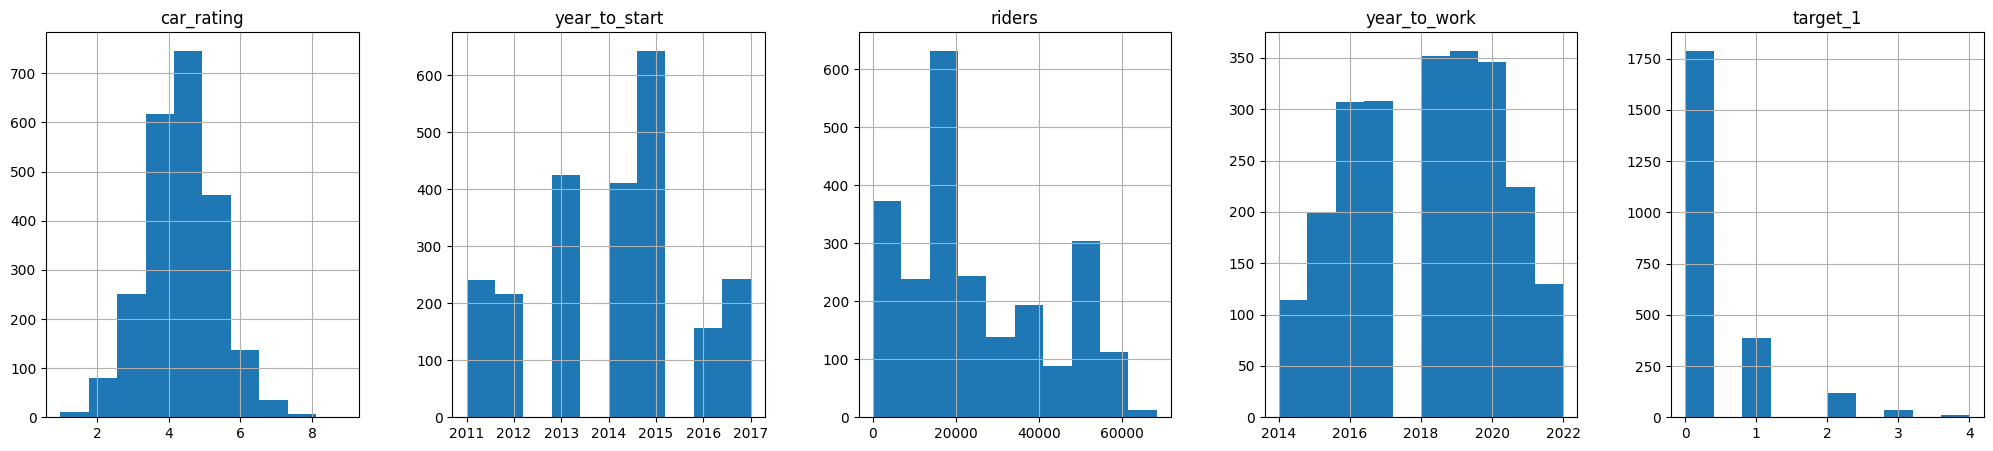

In [31]:
train = pd.read_csv('../data/car_train.csv')
test = pd.read_csv('../data/car_train.csv').drop(['target_1', 'target_2'], axis=1, errors='ignore')

train.hist(figsize=(25, 5), layout = (-1, 5))
train.sample(5)

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   car_id         2337 non-null   object 
 1   model          2337 non-null   object 
 2   car_type       2337 non-null   object 
 3   fuel_type      2337 non-null   object 
 4   car_rating     2337 non-null   float64
 5   year_to_start  2337 non-null   int64  
 6   riders         2337 non-null   int64  
 7   year_to_work   2337 non-null   int64  
 8   target_1       2337 non-null   int64  
 9   target_2       2337 non-null   object 
dtypes: float64(1), int64(4), object(5)
memory usage: 182.7+ KB


# Добавляем признаки

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
451296,P69180946E,f-6408484O,O1A,2020-03-01,5.69,228,2958,53,86.000000,2,2735.130193,0,-0.462166,-9.900
75891,T66079298C,E86595365Q,g1V,2020-01-15,3.85,8,75,43,60.000000,1,390.263333,0,-0.837417,-1.979
404162,L46218787x,c-2186740v,V1H,2020-03-12,4.62,40,314,74,76.597767,0,3049.940073,0,-31.045231,3.863
565560,f39462885s,m50153759z,k1d,2020-02-02,4.39,136,1628,53,92.307876,1,2984.209376,0,-7.529032,-6.551
20345,A43932336E,B-1779073Q,G1V,2020-03-26,6.91,9,84,33,72.000000,0,311.303924,0,-9.821107,6.838


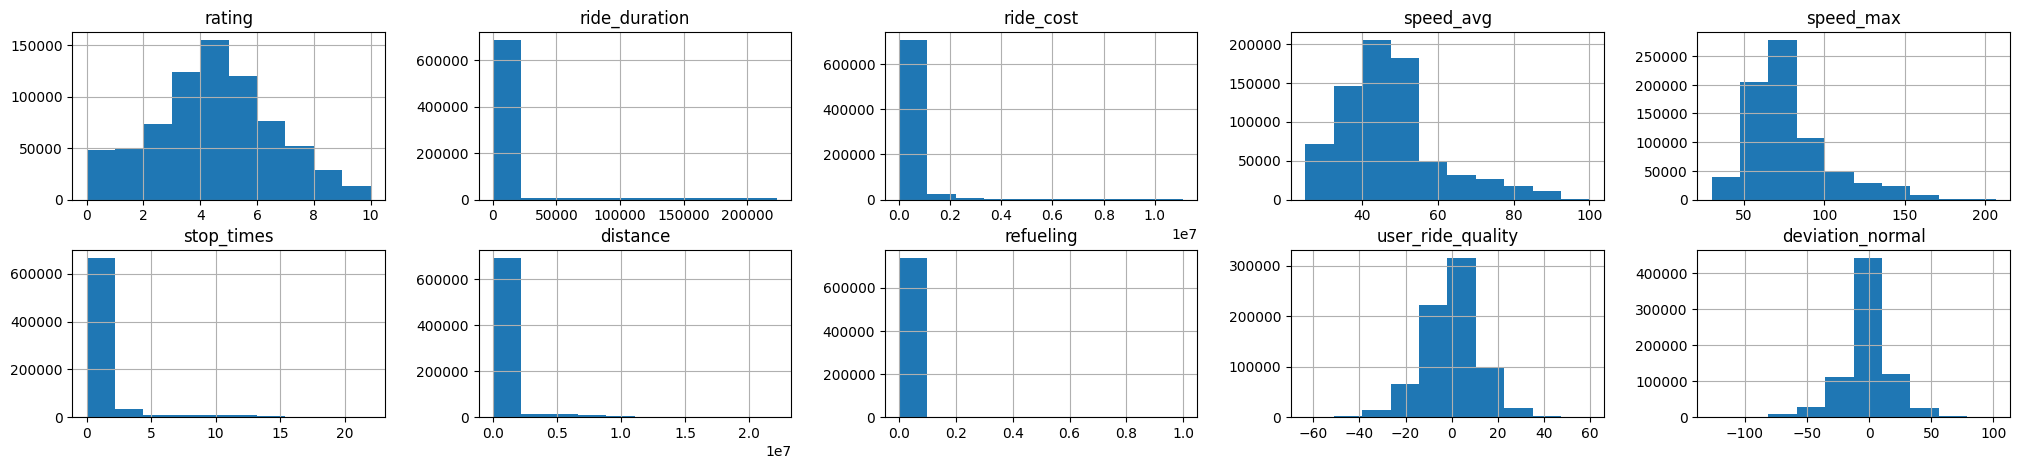

In [29]:
path = '../data/rides_info.csv'
rides = pd.read_csv(path)
rides.hist(figsize=(25, 5), layout = (-1, 5))
rides.sample(5)

In [33]:
f = lambda x: x.nunique()
rides_df_gr = rides.groupby('car_id', as_index=False).agg(mean_rating = ('speed_avg', 'mean'),
                                                   distance_sum = ('distance', 'sum'),
                                                   rating_min = ('rating', 'min'),
                                                   speed_max = ('speed_max', 'max'),
                                                   user_ride_quality_median = ('user_ride_quality', 'median'), 
                                                   deviation_normal_count = ('deviation_normal', 'count'),
                                                   user_uniq = ('user_id', f))


rides_df_gr.head(2)

,car_id,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,A-1068587k,44.390805,4.974618e+07,0.1,123.298894,12.530145,174,173
1,A-1122233S,50.310345,6.662596e+07,0.1,176.515698,-2.452621,174,173


In [34]:
def add_featues(df):
    
    if 'mean_rating' not in df.columns:
        return df.merge(rides_df_gr, on = 'car_id', how = 'left')
    
    return df
    
    
train = add_featues(train)
test = add_featues(test)

# Классифицируем признаки

In [35]:
features2drop = ['car_id'] 
targets = ['target_2']  
cat_features = ['car_type', 'fuel_type', 'model'] 

filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)] #+ cat_features 
num_features = [i for i in filtered_features if i not in cat_features]


print('cat_features :', len(cat_features), cat_features)
print('num_features :', len(num_features), num_features)
print('targets', targets)

cat_features : 3 ['car_type', 'fuel_type', 'model']
num_features : 12 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_1', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'deviation_normal_count', 'user_uniq']
targets ['target_2']


In [ ]:
n_splits = 3 # kfolds
print('num folds', n_splits)
targets = ['target_2']
clfs = []

# параметры валидации, обучение будет идти на n_splits фолдах

X = train[filtered_features].drop(targets, axis=1, errors='ignore')
y = train[targets]

scores = []
kf = KFold(n_splits=n_splits, shuffle=True, random_state=7575)
for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index] 
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    train_dataset = Pool(data=X_train, label=y_train, cat_features=cat_features)
    eval_dataset = Pool(data=X_test, label=y_test, cat_features=cat_features)

    print(X_train.shape, y_train.shape)
    clf = CatBoostClassifier(
                          depth = 4,
                          iterations = 3500, 
                          learning_rate = 0.05953207713558619,
                          
                          loss_function='MultiClass', # MultiLogloss
                          # eval_metric = 'Precision', # F1:macro', #'AUC:hints=skip_train~false',
                          custom_metric =['Recall'], # 'AUC', 'Accuracy'],
                            
                          # Главная фишка катбуста - работа с категориальными признаками
                          cat_features = cat_features, 
        
                          # Регуляризация и ускорение
                          colsample_bylevel =  0.09874152157026818,
                          subsample = 0.9563761143682146,
                             
                          l2_leaf_reg = 9,
                          min_data_in_leaf = 243,
                          max_bin = 187,
                             
                          bootstrap_type='Bernoulli',
                          # ignored_features = ignored_features,
                          task_type='CPU',
                          random_seed=42,   
                          auto_class_weights = 'SqrtBalanced',
                             
                          early_stopping_rounds = 5
                            )

    clfs.append(clf)

    clf.fit(train_dataset, eval_set=eval_dataset,
            verbose = 100, use_best_model = True, plot = False)

    # scores.append(clf.best_score_['validation']['MultiClass'])
    scores.append(np.mean([v for k, v in clf.best_score_['validation'].items() if 'Recall' in k], dtype = 'float16'))
    # clf.save_model("../tmp_data/cool_catboost_model_{}_deep".format(n))

assert len(clfs) == n_splits
print('mean Recalls core --------->', np.mean(scores, dtype = 'float16'), np.std(scores, dtype = 'float16'))

# Данные по поездкам

In [7]:
rides_info = pd.read_csv('../data/rides_info.csv')
rides_info.head()

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,car_rating,user_ride_quality,deviation_normal,killer_fs
0,p39801394j,A15425558p,C1K,2020-01-01,3.18,5.957960,4,44.496105,61.0,0,1.570904,0,3.6,-0.062930,-0.230,125
1,m16051863U,A15425558p,U1W,2020-01-01,4.21,5.456846,5,81.610809,61.0,0,0.866656,0,3.6,0.073357,-0.529,125
2,N20337367P,A15425558p,L1S,2020-01-01,5.21,3.685837,4,66.163165,37.0,0,9.446523,0,3.6,-0.172842,-0.508,125
3,I21127999v,A15425558p,w1M,2020-01-02,3.44,5.727855,4,71.031014,44.0,0,0.349418,0,3.6,-0.386239,-0.788,125
4,Q20018877P,A15425558p,h1k,2020-01-02,3.98,6.289984,5,55.757694,45.0,0,2.419054,0,3.6,-0.246013,-1.183,125


# Данные по ремонту и обслуживанию машин

In [9]:
fix_info = pd.read_csv('../data/fix_info.csv')
fix_info.head()

,work_type,destroy_degree,work_duration,car_id,worker_id,sex,fix_date
0,refuel,0.0,5,R21640888H,YG,1,2020-6-20 2:13
1,reparking,0.0,11,f15244210z,DR,1,2020-1-9 20:21
2,reparking,0.0,11,J91600067B,NM,1,2019-7-24 7:1
3,reparking,0.0,11,X72229940l,UZ,1,2019-7-10 8:25
4,repair,5.9,51,A15425558p,HS,0,2019-11-12 6:28


# Данные по водителям 

In [11]:
driver_info = pd.read_csv('../data/rider_info.csv')
driver_info.head()

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
0,27,7.9,865,11,x17437965O,1,2019-4-2
1,46,7.0,2116,9,l12362316r,0,2021-11-19
2,52,7.0,947,3,I11098715w,0,2021-1-15
3,37,5.9,18,8,l12618125L,0,2019-11-20
4,39,7.3,428,2,E14375829u,0,2019-7-23
